# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [10]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import ameritrade_functions as amc
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('JointHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['JOINT']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-27 16:40:57,717|JointHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-27 16:40:58,855|JointHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-27 00:00:00|2022-11-25 00:00:00
2022-11-27 16:40:58,890|JointHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-27 16:40:58,891|JointHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-27 16:40:59,107|JointHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-27 16:40:59,116|JointHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.015
2022-11-27 16:40:59,117|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.2
2022-11-27 16:40:59,117|JointHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-27 16:44:32,587|JointHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.85|501->425


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-27 16:44:32,605|JointHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|425
2022-11-27 16:44:32,690|JointHoldingsAdjustement|INFO|OPT_DATE|2022-11-25 00:00:00


C:\Users\HP-Z440\anaconda3\envs\svi_tt_p308\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2022-11-27 16:44:46,630|JointHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01500000


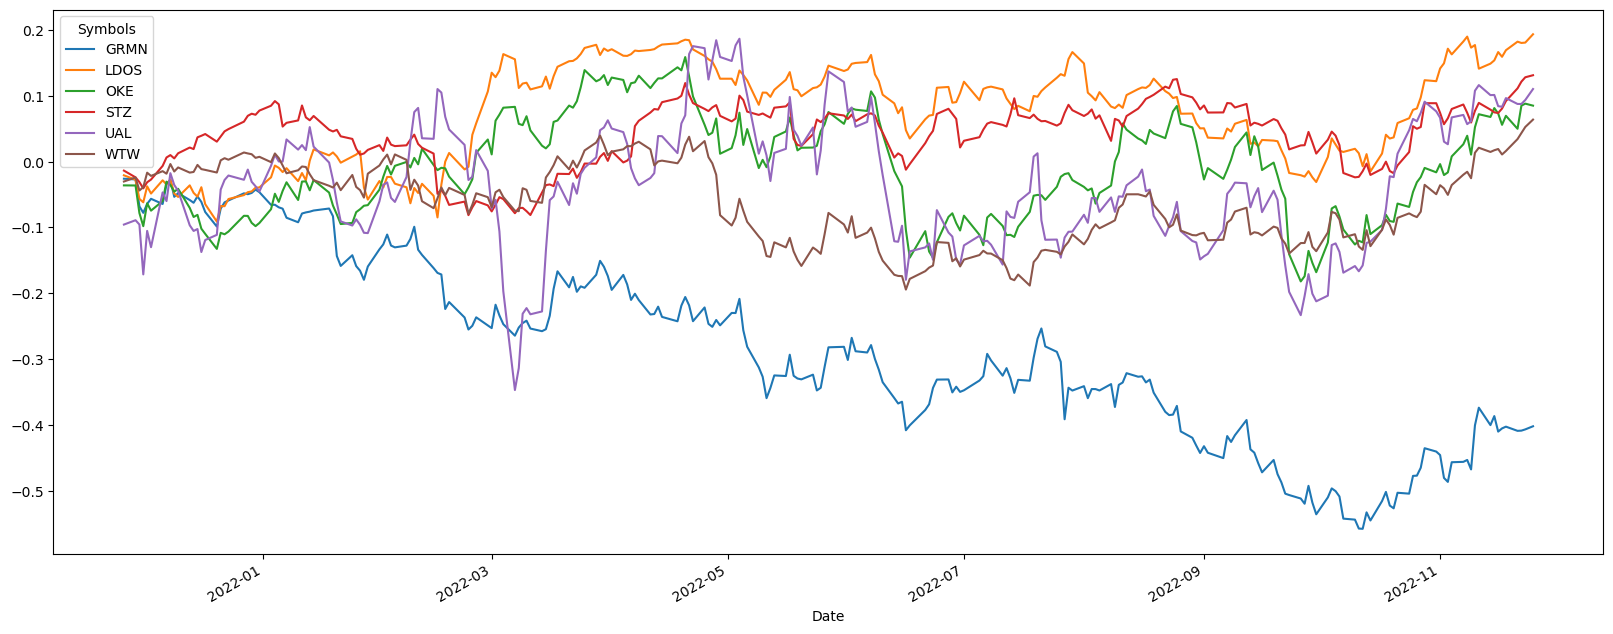

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-27 16:44:47,025|JointHoldingsAdjustement|INFO|STOCK|GRMN                |HOLDING|0.200000
2022-11-27 16:44:47,026|JointHoldingsAdjustement|INFO|STOCK|LDOS                |HOLDING|0.055528
2022-11-27 16:44:47,027|JointHoldingsAdjustement|INFO|STOCK|OKE                 |HOLDING|0.200000
2022-11-27 16:44:47,028|JointHoldingsAdjustement|INFO|STOCK|STZ                 |HOLDING|0.200000
2022-11-27 16:44:47,029|JointHoldingsAdjustement|INFO|STOCK|UAL                 |HOLDING|0.144472
2022-11-27 16:44:47,030|JointHoldingsAdjustement|INFO|STOCK|WTW                 |HOLDING|0.200000


In [11]:
td_ameritrade = amc.AmeritradeRest()
td_ameritrade.authenticate()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,910047109,UAL,"United Airlines Holdings, Inc. - Common Stock",NASDAQ,EQUITY,53.115,30.5400,0.00,0.00,,...,0.00000,0.0,0.0,0.0,0.000,,1.33715,4824850.0,4824845.0,194452980.0
1,682680103,OKE,"ONEOK, Inc. Common Stock",NYSE,EQUITY,75.070,50.5000,3.74,5.72,2022-10-31 00:00:00.000,...,71.99105,0.0,0.0,0.0,0.935,2022-11-14 00:00:00.000,1.67064,2288660.0,2288660.0,54093180.0
2,21036P108,STZ,"Constellation Brands, Inc. Common Stock",NYSE,EQUITY,261.525,207.5916,3.20,1.24,2022-11-03 00:00:00.000,...,12.04015,0.0,0.0,0.0,0.800,2022-11-18 00:00:00.000,0.98790,1012630.0,1012633.0,20957580.0
3,G96629103,WTW,Willis Towers Watson Public Limited Company - ...,NASDAQ,EQUITY,244.730,187.8900,3.28,1.34,2022-09-29 00:00:00.000,...,8.02709,0.0,0.0,0.0,0.820,2022-10-17 00:00:00.000,0.77005,647810.0,647809.0,12928810.0
4,H2906T109,GRMN,Garmin Ltd. Common Stock (Switzerland),NYSE,EQUITY,140.930,76.3700,2.92,3.21,2022-12-14 00:00:00.000,...,11.85881,0.0,0.0,0.0,0.730,2022-12-30 00:00:00.000,0.97519,756220.0,756221.0,21442890.0
5,525327102,LDOS,"Leidos Holdings, Inc. Common Stock",NYSE,EQUITY,111.120,81.0700,1.44,1.32,2022-12-14 00:00:00.000,...,7.95850,0.0,0.0,0.0,0.360,2022-12-30 00:00:00.000,0.80734,1003070.0,1003067.0,16234220.0


Tickers:   0%|          | 0/6 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/6 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_16272\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


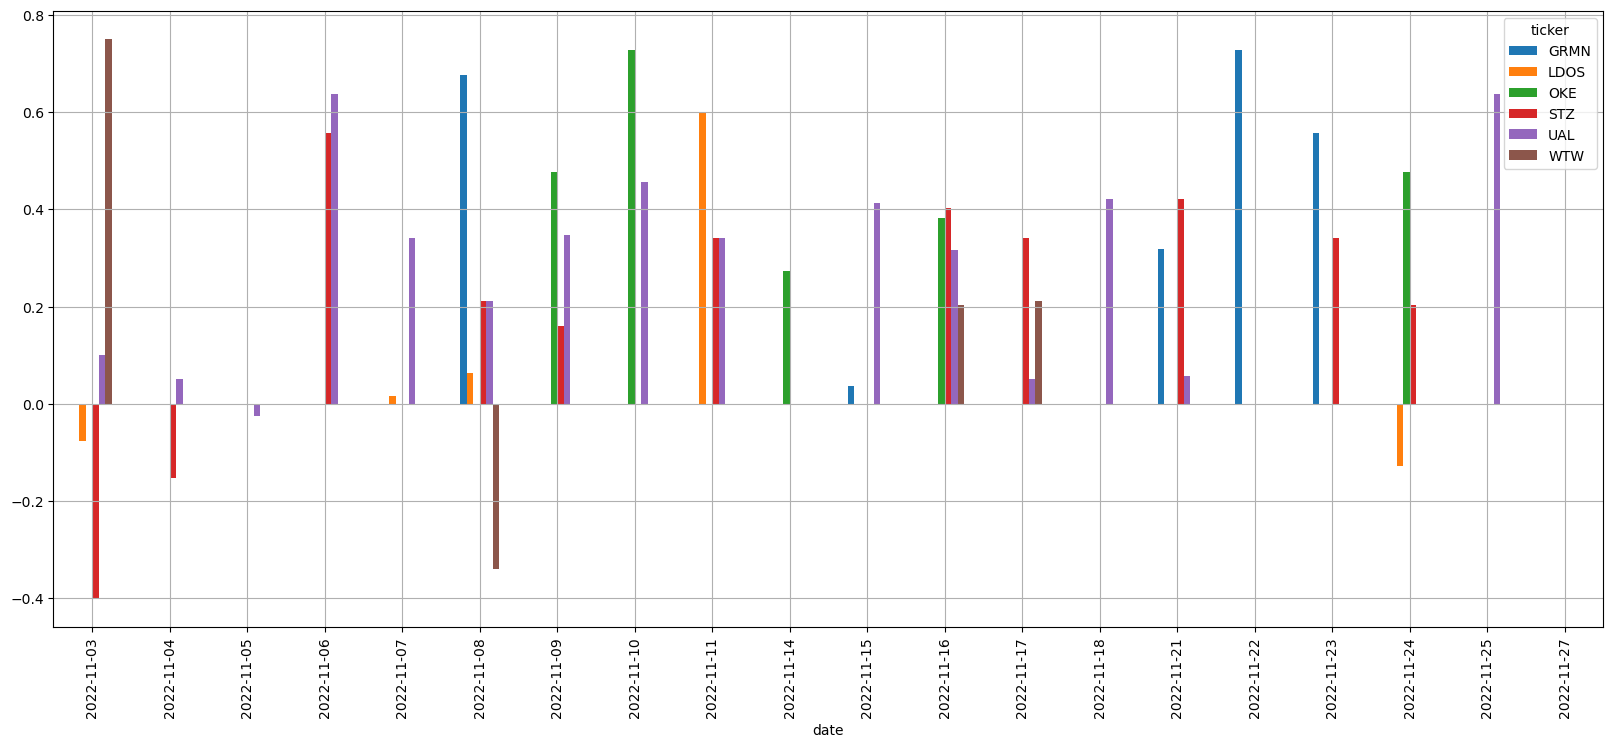

In [12]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [13]:
if len(td_ameritrade.authorization) == 0:
    logger.error('Error: No authorization data: {}'.format(td_ameritrade.authorization))
    raise SystemExit
else:
    logger.info('You have authorization')

In [14]:
td_ameritrade.authorization['refresh_token_expires_in'] / 60 / 60 / 24

90.0

In [15]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 ETR               0.0     112.25500             0.0   
         HSY               0.0     225.48000             0.0   
         VTR               0.0      43.67893             0.0   
         WKHS              0.0      10.49180             0.0   
         EEENF             0.0       0.04980             0.0   
         FGPHF             0.0       0.10927             0.0   
         WAB               0.0      98.91520             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 ETR                      0.0                             0.0   
         HSY                      0.0                             0.0   
         VTR                      0.0                             0.0   
         WKHS                     0.0                             0.0   
         EEENF                    0.0                             0.0   
         FGPHF                    0.0                             0.0   
         WAB                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 ETR             22.0                 22.0                   0.0   
         HSY             11.0                 11.0                   0.0   
         VTR             56.0                 56.0                   0.0   
         WKHS           300.0                300.0                   0.0   
         EEENF          250.0                250.0                   0.0   
         FGPHF        25000.0              25000.0                   0.0   
         WAB             25.0                 25.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 ETR         2502.50                  750.75   
         HSY         2571.36                  771.41   
         VTR         2547.44                  764.23   
         WKHS         648.00                  600.00   
         EEENF          1.58                    0.00   
         FGPHF       2145.00                    0.00   
         WAB         2522.00                  756.60   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 ETR                            22.0    EQUITY  29364G103           0   
         HSY                            11.0    EQUITY  427866108           0   
         VTR                            56.0    EQUITY  92276F100           0   
         WKHS                          300.0    EQUITY  98138J206           0   
         EEENF                         250.0    EQUITY  Q3394D101           0   
         FGPHF                       25000.0    EQUITY  Q3860H107           0   
         WAB                            25.0    EQUITY  929740108           0   

                type  
account  symbol       
#---2021 ETR       0  
         HSY       0  
         VTR       0  
         WKHS      0  
         EEENF     0  
         FGPHF     0  
         WAB       0

In [16]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---2021 ETR               0.0     112.25500             0.0   
         HSY               0.0     225.48000             0.0   
         VTR               0.0      43.67893             0.0   
         WAB               0.0      98.91520             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---2021 ETR                      0.0                             0.0   
         HSY                      0.0                             0.0   
         VTR                      0.0                             0.0   
         WAB                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---2021 ETR             22.0                 22.0                   0.0   
         HSY             11.0                 11.0                   0.0   
         VTR             56.0                 56.0                   0.0   
         WAB             25.0                 25.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---2021 ETR         2502.50                  750.75   
         HSY         2571.36                  771.41   
         VTR         2547.44                  764.23   
         WAB         2522.00                  756.60   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---2021 ETR                            22.0    EQUITY  29364G103           0   
         HSY                            11.0    EQUITY  427866108           0   
         VTR                            56.0    EQUITY  92276F100           0   
         WAB                            25.0    EQUITY  929740108           0   

                type  
account  symbol       
#---2021 ETR       0  
         HSY       0  
         VTR       0  
         WAB       0

In [18]:
cash_equivelants_df = td_ameritrade.get_account_portfolio_data(masked_account_number, 'CASH_EQUIVALENT')
cash_equivelants_df

,,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,description,type
account,symbol,,,,,,,,,,,,,,,
#---2021,MMDA1,0.0,0.99903,0.0,0.0,0.0,702.37,702.37,0.0,702.37,0.0,702.37,CASH_EQUIVALENT,9ZZZFD104,FDIC INSURED DEPOSIT ACCOUNT CORE NOT COVERE...,MONEY_MARKET_FUND


In [19]:
amount_for_trading = cash_equivelants_df.marketValue.sum() + stocks_to_sell.marketValue.sum()
amount_for_trading

10845.670000000002

### Submit and montior sell orders

In [20]:
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---2021 for 22.0 shares of ETR...
Placed SELL order on #---2021 for 22.0 shares of ETR
Placing SELL order on #---2021 for 11.0 shares of HSY...
Placed SELL order on #---2021 for 11.0 shares of HSY
Placing SELL order on #---2021 for 56.0 shares of VTR...
Placed SELL order on #---2021 for 56.0 shares of VTR
Placing SELL order on #---2021 for 25.0 shares of WAB...
Placed SELL order on #---2021 for 25.0 shares of WAB


In [17]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


2022-11-20 22:14:02,930|WDM|INFO|



====== WebDriver manager ======


2022-11-20 22:14:02,935|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-20 22:14:02,979|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-20 22:14:02,983|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-20 22:14:03,051|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


KeyboardInterrupt: 

In [18]:
td_ameritrade = amc.AmeritradeRest()
td_ameritrade.authenticate()
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

2022-11-21 09:44:12,928|WDM|INFO|



====== WebDriver manager ======


2022-11-21 09:44:12,934|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-21 09:44:12,995|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-21 09:44:12,997|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Trying to download new driver from https://chromedriver.storage.googleapis.com/107.0.5304.62/chromedriver_win32.zip


2022-11-21 09:44:13,125|WDM|INFO|Trying to download new driver from https://chromedriver.storage.googleapis.com/107.0.5304.62/chromedriver_win32.zip


Driver has been saved in cache [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62]


2022-11-21 09:44:13,538|WDM|INFO|Driver has been saved in cache [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62]


initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             11314.090000
initialBalances_moneyMarketFund      811.990000
currentBalances_cashBalance         9759.320000
currentBalances_equity             11288.310000
currentBalances_moneyMarketFund      811.990000
current_return                        -0.002281
Name: #---2021, dtype: float64

9759.32
811.99
2022-11-21 09:44:53,823|JointHoldingsAdjustement|INFO|INVESTMENT_AMT|10571.31


In [19]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 10571.31
Amount to invest: 10000


In [20]:
long_weights

,optimalWeights
ETR,0.2
GWW,0.2
HSY,0.2
VTR,0.2
WAB,0.2


In [21]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-21 09:45:18.654350
Initial investment amount: 10000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
ETR,111.92,0.2,2000.0,17
GWW,597.03,0.2,2000.0,3
HSY,225.21,0.2,2000.0,8
VTR,44.07,0.2,2000.0,45
WAB,99.16,0.2,2000.0,20


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
ETR,111.92,0.25,2500.0,22,2462.24
HSY,225.21,0.25,2500.0,11,2477.31
VTR,44.07,0.25,2500.0,56,2467.92
WAB,99.16,0.25,2500.0,25,2479.00


Total cost: 9886.470000000001


### Place buy orders

In [22]:
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,29364G103,ETR,Entergy Corporation Common Stock,NYSE,EQUITY,126.815,94.94,4.280,3.82,2022-11-10 00:00:00.000,...,4.93359,0.0,0.0,0.0,1.070,2022-12-01 00:00:00.000,0.62159,1121350.0,1121349.0,24871780.0
1,92276F100,VTR,"Ventas, Inc. Common Stock",NYSE,EQUITY,64.020,35.33,1.800,4.08,2022-09-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.450,2022-10-14 00:00:00.000,1.16199,2548040.0,2548037.0,46970510.0
2,929740108,WAB,Westinghouse Air Brake Technologies Corporatio...,NYSE,EQUITY,102.110,78.26,0.600,0.61,2022-11-10 00:00:00.000,...,18.88636,0.0,0.0,0.0,0.150,2022-11-28 00:00:00.000,1.49413,1043350.0,1043345.0,18500300.0
3,427866108,HSY,The Hershey Company Common Stock,NYSE,EQUITY,241.450,175.08,4.144,1.84,2022-11-17 00:00:00.000,...,29.29452,0.0,0.0,0.0,1.036,2022-12-15 00:00:00.000,0.35304,1312470.0,1312471.0,20067850.0


In [23]:
print(datetime.today())
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-21 09:45:36.173788
2022-11-21 09:45:36,173|WDM|INFO|



====== WebDriver manager ======


2022-11-21 09:45:36,175|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-21 09:45:36,341|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-21 09:45:36,343|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-21 09:45:36,411|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing BUY order on 768492021 for 22.0 shares of ETR:EQUITY...
Placed BUY order on #---2021 for 22.0 shares of ETR
Placing BUY order on 768492021 for 11.0 shares of HSY:EQUITY...
Placed BUY order on #---2021 for 11.0 shares of HSY
Placing BUY order on 768492021 for 56.0 shares of VTR:EQUITY...
Placed BUY order on #---2021 for 56.0 shares of VTR
Placing BUY order on 768492021 for 25.0 shares of WAB:EQUITY...
Placed BUY order on #---2021 for 25.0 shares of WAB


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]